In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from pandas.io.json import json_normalize
import json
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

def load_df(csv_path='../input/ga-customer-revenue-prediction/train.csv', nrows=None):
    JSON_COLUMNS = ['device', 'geoNetwork', 'totals', 'trafficSource']
    
    df = pd.read_csv(csv_path, 
                     converters={column: json.loads for column in JSON_COLUMNS}, 
                     dtype={'fullVisitorId': 'str'}, # Important!!
                     nrows=nrows)
    
    for column in JSON_COLUMNS:
        column_as_df = json_normalize(df[column])
        column_as_df.columns = [f"{column}.{subcolumn}" for subcolumn in column_as_df.columns]
        df = df.drop(column, axis=1).merge(column_as_df, right_index=True, left_index=True)
    print(f"Loaded {os.path.basename(csv_path)}. Shape: {df.shape}")
    return df

['kernel-for-data', 'customer-revenue-prediction', 'ga-customer-revenue-prediction']


In [ ]:
# X_train = load_df()
# X_test = load_df("../input/ga-customer-revenue-prediction/test.csv")
# X_train.to_csv("train-flat.csv", index=False)
# X_test.to_csv("test-flat.csv", index=False)

In [2]:
X_train = pd.read_csv("../input/kernel-for-data/train-flat.csv", low_memory = False)

In [3]:
X_test = pd.read_csv("../input/kernel-for-data/test-flat.csv", low_memory = False)

Here, we are checking if the unique values in the columns including Nan are greater than 1 or not. If not, the column has only Nan in it and thus we're dropping those columns.

In [4]:
columns = [col for col in X_train.columns if X_train[col].nunique() > 1]
print(columns)
X_train = X_train[columns]

['channelGrouping', 'date', 'fullVisitorId', 'sessionId', 'visitId', 'visitNumber', 'visitStartTime', 'device.browser', 'device.deviceCategory', 'device.isMobile', 'device.operatingSystem', 'geoNetwork.city', 'geoNetwork.continent', 'geoNetwork.country', 'geoNetwork.metro', 'geoNetwork.networkDomain', 'geoNetwork.region', 'geoNetwork.subContinent', 'totals.hits', 'totals.pageviews', 'totals.transactionRevenue', 'trafficSource.adContent', 'trafficSource.adwordsClickInfo.adNetworkType', 'trafficSource.adwordsClickInfo.gclId', 'trafficSource.adwordsClickInfo.page', 'trafficSource.adwordsClickInfo.slot', 'trafficSource.campaign', 'trafficSource.keyword', 'trafficSource.medium', 'trafficSource.referralPath', 'trafficSource.source']


In [5]:
columns.remove('totals.transactionRevenue')

In [6]:
X_test = X_test[columns]

COnverting the date from string to pandas date format.

In [7]:
X_train['date'] = pd.to_datetime(X_train['date'].apply(lambda x: str(x)[:4] + '-' + str(x)[4:6] + '-' + str(x)[6:]))
X_test['date'] = pd.to_datetime(X_test['date'].apply(lambda x: str(x)[:4] + '-' + str(x)[4:6] + '-' + str(x)[6:]))

Adding new features like day,month,year,week of the year

In [8]:
X_train['day'] = X_train.date.dt.dayofweek
X_train['month'] = X_train.date.dt.month
X_train['year'] = X_train.date.dt.year
X_train['weekOfTheYear'] = X_train.date.dt.weekofyear

X_test['day'] = X_test.date.dt.dayofweek
X_test['month'] = X_test.date.dt.month
X_test['year'] = X_test.date.dt.year
X_test['weekOfTheYear'] = X_test.date.dt.weekofyear

In [9]:
percent = (100 * X_train.isnull().sum() / X_train.shape[0]).sort_values(ascending=False)
print(percent)

trafficSource.adContent                         98.788694
totals.transactionRevenue                       98.725728
trafficSource.adwordsClickInfo.slot             97.625195
trafficSource.adwordsClickInfo.page             97.625195
trafficSource.adwordsClickInfo.adNetworkType    97.625195
trafficSource.adwordsClickInfo.gclId            97.614018
trafficSource.referralPath                      63.377425
trafficSource.keyword                           55.655102
totals.pageviews                                 0.011066
device.operatingSystem                           0.000000
device.isMobile                                  0.000000
device.deviceCategory                            0.000000
device.browser                                   0.000000
visitStartTime                                   0.000000
weekOfTheYear                                    0.000000
geoNetwork.continent                             0.000000
visitNumber                                      0.000000
visitId       

In [10]:
percent = (100 * X_test.isnull().sum() / X_test.shape[0]).sort_values(ascending=False)
percent

trafficSource.adContent                         93.315264
trafficSource.adwordsClickInfo.page             93.312406
trafficSource.adwordsClickInfo.slot             93.312406
trafficSource.adwordsClickInfo.adNetworkType    93.312406
trafficSource.adwordsClickInfo.gclId            93.306441
trafficSource.referralPath                      70.755850
trafficSource.keyword                           48.594479
totals.pageviews                                 0.017274
device.operatingSystem                           0.000000
device.isMobile                                  0.000000
device.deviceCategory                            0.000000
device.browser                                   0.000000
visitStartTime                                   0.000000
weekOfTheYear                                    0.000000
geoNetwork.continent                             0.000000
visitNumber                                      0.000000
visitId                                          0.000000
sessionId     

Dropping those columns which have NaN% greater than 75

In [11]:
drop_columns = ['trafficSource.adContent', 'trafficSource.adwordsClickInfo.page', 'trafficSource.adwordsClickInfo.slot', 'trafficSource.adwordsClickInfo.adNetworkType', 'trafficSource.adwordsClickInfo.gclId', 'trafficSource.referralPath']

In [12]:
X_train.drop(drop_columns, axis=1, inplace=True)
X_test.drop(drop_columns, axis=1, inplace=True)

In [13]:
X_train['trafficSource.keyword'].fillna('nan', inplace=True)
X_test['trafficSource.keyword'].fillna('nan', inplace=True)

In [14]:
def add_new_category(x):
    x = str(x).lower()
    if x == 'nan':
        return 'nan'
    
    x = ''.join(x.split())
    
    if 'youtube' in x or 'you' in x or 'yo' in x or 'tub' in x:
        return 'youtube'
    elif 'google' in x or 'goo' in x or 'gle' in x:
        return 'google'
    else:
        return 'other'

Majority of the data points contain trafficSource.keyword as either some substring of either google of youtube. Adding actual feature names in that column using the function.

In [15]:
X_train['trafficSource.keyword'] = X_train['trafficSource.keyword'].apply(add_new_category)
X_test['trafficSource.keyword'] = X_test['trafficSource.keyword'].apply(add_new_category)

In [16]:
X_train["totals.transactionRevenue"] = X_train["totals.transactionRevenue"].astype('float')

In [17]:
device_mobile_val = []
for i in X_train['device.isMobile'].unique():
    #t = X_train.loc[X_train['device.isMobile'] == i, 'totals.transactionRevenue'].mean()
    device_mobile_val.append(X_train.loc[X_train['device.isMobile'] == i, 'totals.transactionRevenue'].mean())

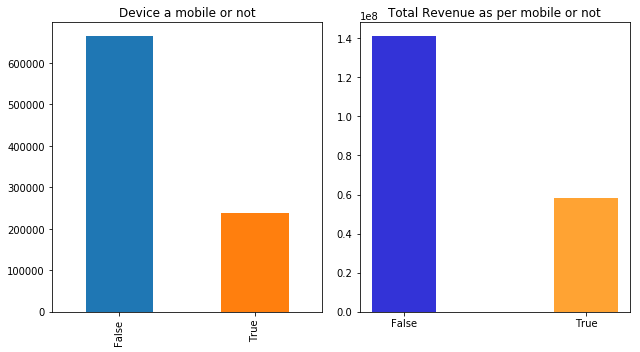

In [18]:
plt.figure(figsize = (9,5))
plt.subplot(1,2,1)
X_train['device.isMobile'].value_counts().sort_values(ascending = False).plot.bar()
plt.title('Device a mobile or not')
#plt.show()

plt.subplot(1,2,2)
plt.bar(['False', 'True'],device_mobile_val, width = 0.35, color = ['mediumblue','darkorange'], alpha = 0.8)
plt.title('Total Revenue as per mobile or not')
plt.tight_layout()
plt.show()

In [19]:
X_train['device.isMobile'] = X_train['device.isMobile'].astype(int)
X_test['device.isMobile'] = X_test['device.isMobile'].astype(int)

In [20]:
device_os = []
device_os_names = []

for i in X_train['device.operatingSystem'].unique():
    #t = X_train.loc[X_train['device.isMobile'] == i, 'totals.transactionRevenue'].mean()
    device_os.append(X_train.loc[X_train['device.operatingSystem'] == i, 'totals.transactionRevenue'].sum())
    device_os_names.append(i)
    
import math
for i in range (0,len(device_os)):
    if math.isnan(device_os[i]):
        device_os[i] = 0.0
    
device_os, device_os_names = (list(t) for t in zip(*sorted(zip(device_os, device_os_names))))
device_os.reverse()
device_os_names.reverse()

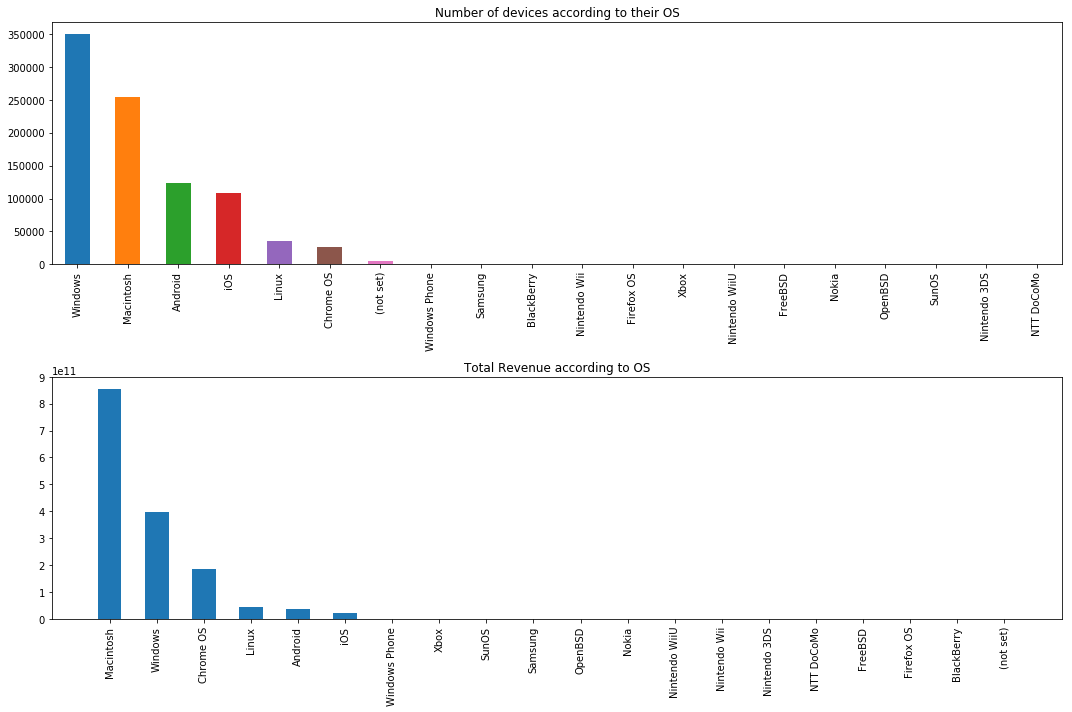

In [21]:
plt.figure(figsize = (15,10))
plt.subplot(2,1,1)

X_train['device.operatingSystem'].value_counts().sort_values(ascending = False).plot.bar()
plt.title('Number of devices according to their OS')

plt.subplot(2,1,2)
plt.xticks(rotation=90)

plt.bar(device_os_names , device_os, width = 0.5)
plt.title('Total Revenue according to OS')
plt.tight_layout()
plt.show()

In [22]:
browser_means = []
browser_names = []

for i in X_train['device.browser'].unique():
    #t = X_train.loc[X_train['device.isMobile'] == i, 'totals.transactionRevenue'].mean()
    browser_means.append(X_train.loc[X_train['device.browser'] == i, 'totals.transactionRevenue'].mean())
    browser_names.append(i)
    
for i in range (0,len(browser_means)):
    if math.isnan(browser_means[i]):
        browser_means[i] = 0.0
    
browser_means, browser_names = (list(t) for t in zip(*sorted(zip(browser_means, browser_names))))
browser_means.reverse()
browser_names.reverse()

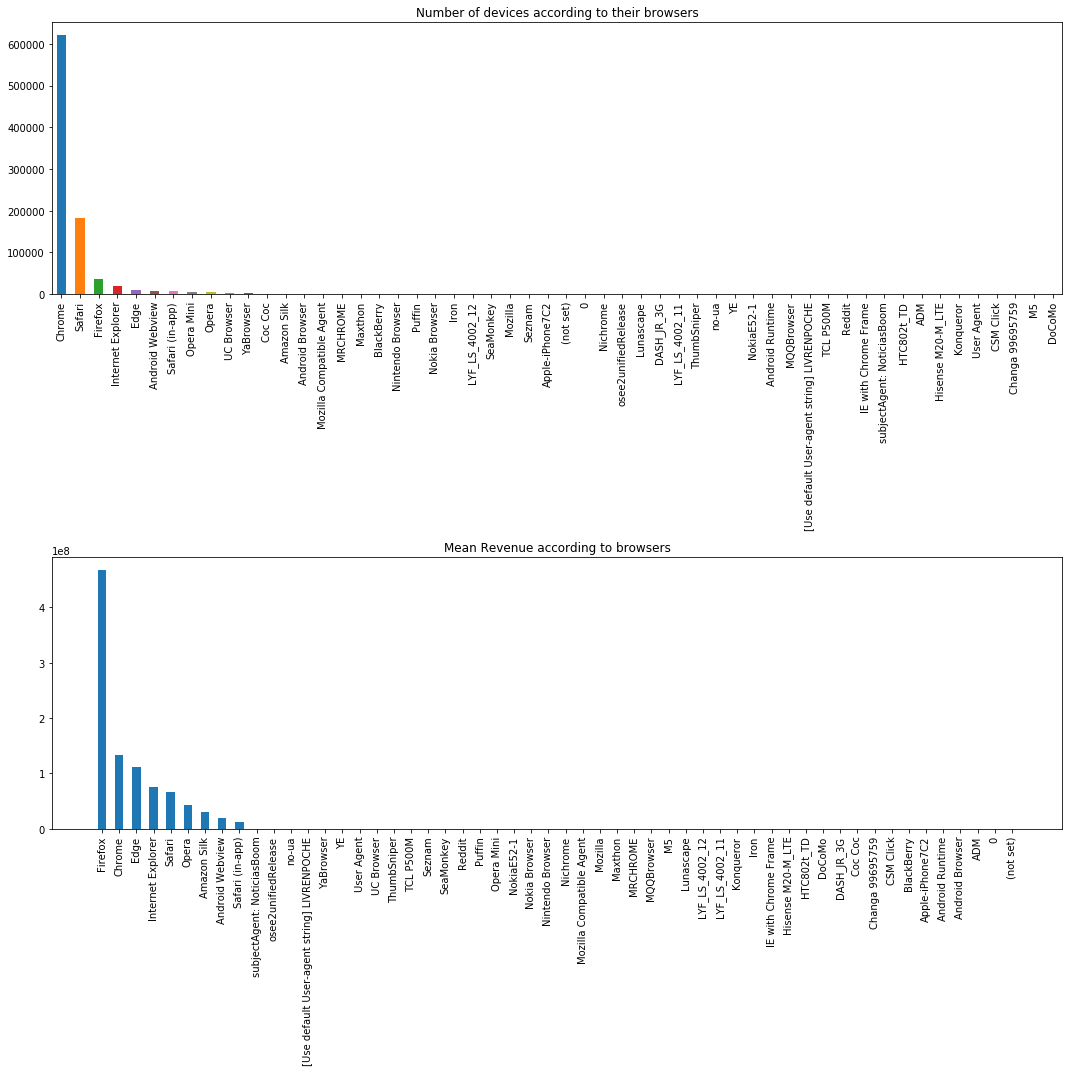

In [23]:
plt.figure(figsize = (15,15))
plt.subplot(2,1,1)
#plt.yticks(np.arange(min(browser_means), max(browser_means) + 50000, 50000))
X_train['device.browser'].value_counts().sort_values(ascending = False).plot.bar()
plt.title('Number of devices according to their browsers')

plt.subplot(2,1,2)
plt.xticks(rotation=90)
#plt.yticks(np.arange(min(browser_means), max(browser_means) + 50000, 50000))
plt.bar(browser_names , browser_means, width = 0.5)
plt.title('Mean Revenue according to browsers')
plt.tight_layout()
plt.show()

<Figure size 360x720 with 0 Axes>

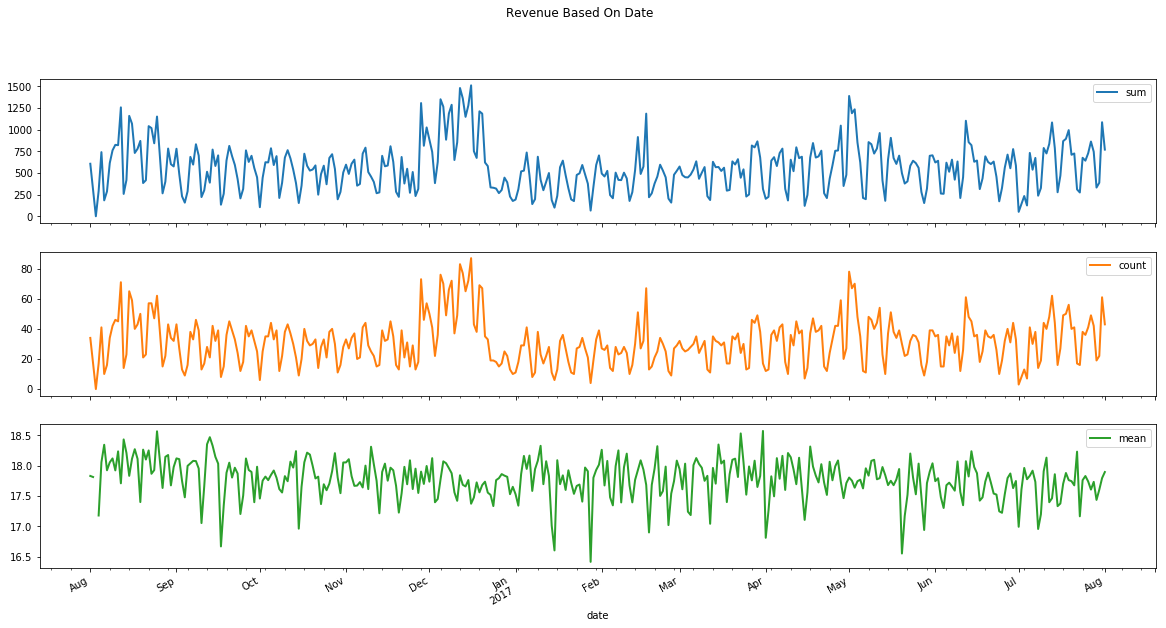

In [24]:
X_train['logRev'] = np.log(X_train['totals.transactionRevenue'])
plt.figure(figsize = (5,10))
X_train.groupby("date")["logRev"].agg(['sum', 'count', 'mean']).plot(subplots=True, sharex=True, title="Revenue Based On Date", linewidth=2,figsize = (20,10))
plt.show()

In [25]:
X_train = X_train.drop(columns = ['logRev'])
X_train.drop('date', axis = 1, inplace = True)
X_test.drop('date', axis = 1, inplace = True)

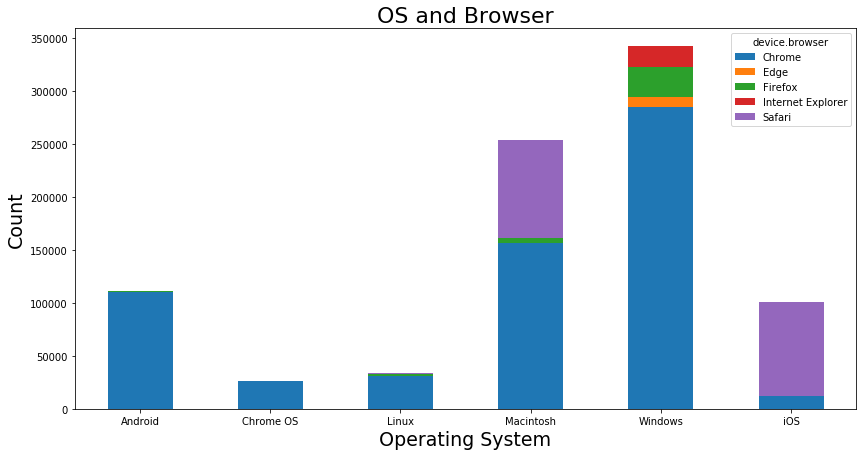

In [26]:
crosstab_eda = pd.crosstab(index=X_train[X_train['device.operatingSystem']\
                                          .isin(X_train['device.operatingSystem']\
                                                .value_counts()[:6].index.values)]['device.operatingSystem'], 
                           
                           columns=X_train[X_train['device.browser'].isin(X_train['device.browser']\
                                                                            .value_counts()[:5].index.values)]['device.browser'])

crosstab_eda.plot(kind="bar",    
                 figsize=(14,7), 
                 stacked=True)  
plt.title("OS and Browser", fontsize=22) 
plt.xlabel("Operating System", fontsize=19) 
plt.ylabel("Count", fontsize=19) 
plt.xticks(rotation=0) 

plt.show() 

In [27]:
X_train['totals.transactionRevenue'] = X_train['totals.transactionRevenue'].fillna(0).astype(float)

In [28]:
import math
geonetwork_means = []
geonetwork_names = []

for i in X_train['geoNetwork.continent'].unique():
    #t = X_train.loc[X_train['device.isMobile'] == i, 'totals.transactionRevenue'].mean()
    geonetwork_means.append(X_train.loc[X_train['geoNetwork.continent'] == i, 'totals.transactionRevenue'].sum())
    geonetwork_names.append(i)
    
for i in range (0,len(geonetwork_means)):
    if math.isnan(geonetwork_means[i]):
        geonetwork_means[i] = 0.0
    
geonetwork_means, geonetwork_names = (list(t) for t in zip(*sorted(zip(geonetwork_means, geonetwork_names))))
geonetwork_means.reverse()
geonetwork_names.reverse()

Text(0.5,1,'Total Revenue according to continents')

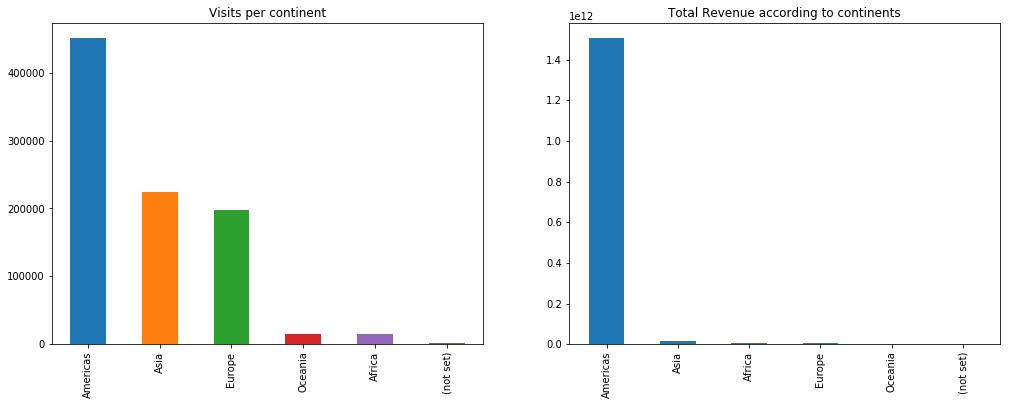

In [29]:
plt.figure(figsize = (17,13))
plt.subplot(221)
#plt.yticks(np.arange(min(browser_means), max(browser_means) + 50000, 50000))
X_train['geoNetwork.continent'].value_counts().sort_values(ascending = False).plot.bar()
plt.title('Visits per continent')

plt.subplot(222)
plt.xticks(rotation=90)
#plt.yticks(np.arange(min(browser_means), max(browser_means) + 50000, 50000))
plt.bar(geonetwork_names , geonetwork_means, width = 0.5)
plt.title('Total Revenue according to continents')


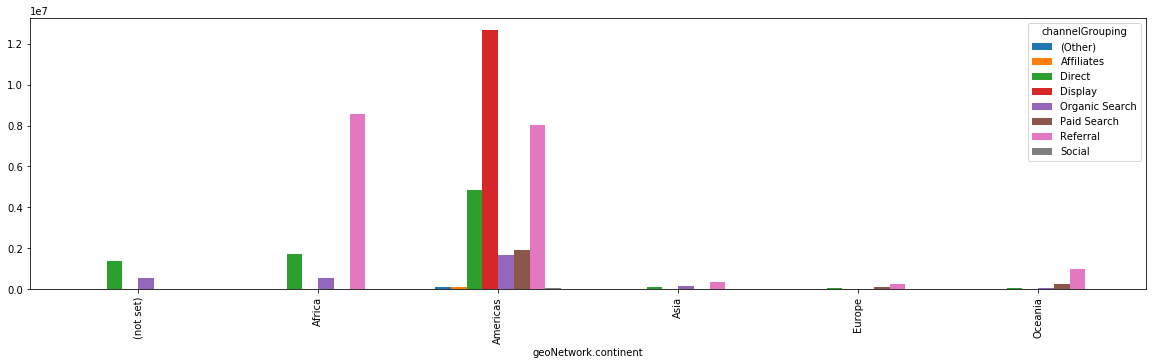

In [30]:
X_train.pivot_table(index='geoNetwork.continent', columns='channelGrouping', values='totals.transactionRevenue').plot(kind='bar', figsize = (20,5), width = 0.7)

In [31]:
import math
geonetwork_city_means = []
geonetwork_city_names = []
geonetwork_city_counts = []

for i in X_train['geoNetwork.city'].unique():
    #t = X_train.loc[X_train['device.isMobile'] == i, 'totals.transactionRevenue'].mean()
    geonetwork_city_means.append(X_train.loc[X_train['geoNetwork.city'] == i, 'totals.transactionRevenue'].sum())
    geonetwork_city_names.append(i)
    
    
geonetwork_city_means, geonetwork_city_names = (list(t) for t in zip(*sorted(zip(geonetwork_city_means, geonetwork_city_names))))
geonetwork_city_means.reverse()
geonetwork_city_names.reverse()

for i in geonetwork_city_names[1:11]:
    geonetwork_city_counts.append(X_train[X_train['geoNetwork.city'] == i].count()[0])

Text(0.5,1,'Total Revenue according to city')

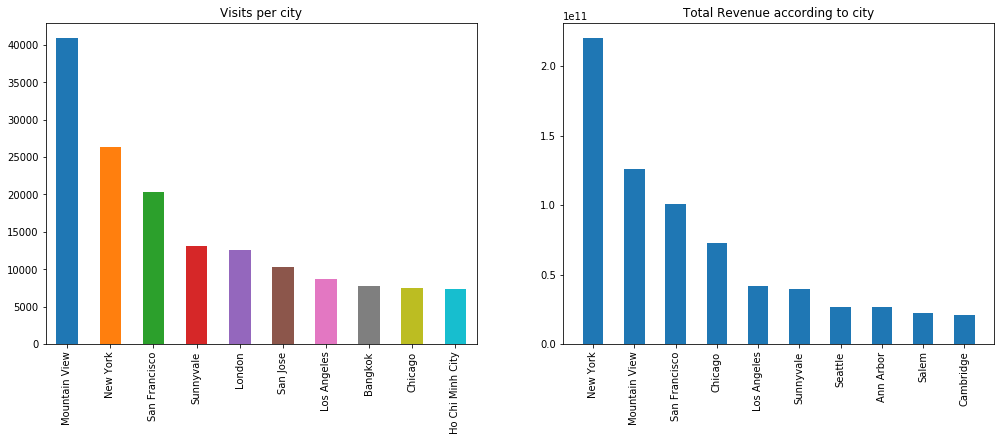

In [32]:
plt.figure(figsize = (17,13))
plt.subplot(221)
#plt.yticks(np.arange(min(browser_means), max(browser_means) + 50000, 50000))
tmp = X_train['geoNetwork.city'].value_counts().sort_values(ascending = False)
del tmp['(not set)']
tmp = tmp[1:11]
tmp.plot.bar()
#X_train['geoNetwork.city'].value_counts().sort_values(ascending = False).plot.bar()
plt.title('Visits per city')

plt.subplot(222)
plt.xticks(rotation=90)
#plt.yticks(np.arange(min(browser_means), max(browser_means) + 50000, 50000))
plt.bar(geonetwork_city_names[1:11] , geonetwork_city_means[1:11], width = 0.5)
plt.title('Total Revenue according to city')


In [33]:
geonetwork_subconti_means = []
geonetwork_subconti_names = []

for i in X_train['geoNetwork.subContinent'].unique():
    #t = X_train.loc[X_train['device.isMobile'] == i, 'totals.transactionRevenue'].mean()
    geonetwork_subconti_means.append(X_train.loc[X_train['geoNetwork.subContinent'] == i, 'totals.transactionRevenue'].mean())
    geonetwork_subconti_names.append(i)
    
for i in range (0,len(geonetwork_subconti_means)):
    if math.isnan(geonetwork_subconti_means[i]):
        geonetwork_subconti_means[i] = 0.0
geonetwork_subconti_means, geonetwork_subconti_names = (list(t) for t in zip(*sorted(zip(geonetwork_subconti_means, geonetwork_subconti_names))))
geonetwork_subconti_means.reverse()
geonetwork_subconti_names.reverse()

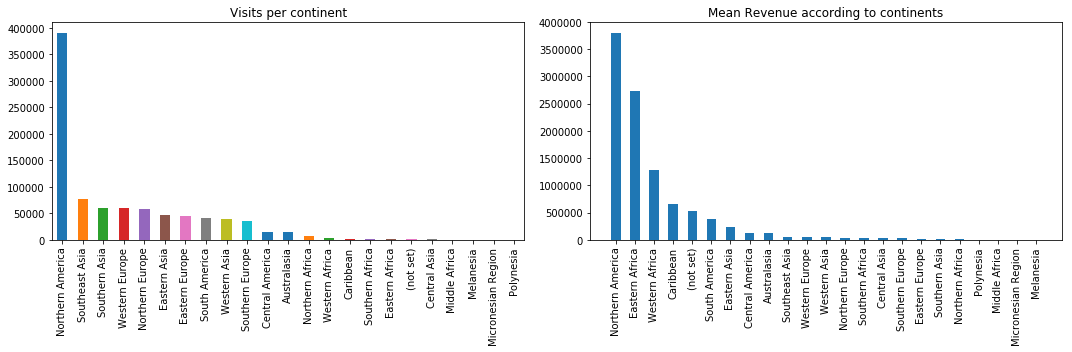

In [34]:
plt.figure(figsize = (15,5))
plt.subplot(1,2,1)
#plt.yticks(np.arange(min(browser_means), max(browser_means) + 50000, 50000))
X_train['geoNetwork.subContinent'].value_counts().sort_values(ascending = False).plot.bar()
plt.title('Visits per continent')

plt.subplot(1,2,2)
plt.xticks(rotation=90)
#plt.yticks(np.arange(min(browser_means), max(browser_means) + 50000, 50000))
plt.bar(geonetwork_subconti_names , geonetwork_subconti_means, width = 0.5)
plt.title('Mean Revenue according to continents')
plt.tight_layout()
plt.show()

In [35]:
categorical = ['device.browser', 'device.deviceCategory', 'device.operatingSystem', 'geoNetwork.city', 'geoNetwork.continent' ,'geoNetwork.country', 'geoNetwork.metro', 'geoNetwork.networkDomain', 'geoNetwork.region', 'geoNetwork.subContinent']

Appending those features which are categorical in the list named "categorical". I will use this list later to encode labels to the categorical features.

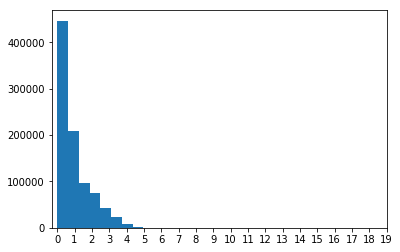

In [36]:
plt.hist(np.log(X_train['totals.hits']))
plt.xticks(np.arange(0,20))
plt.show()

In [37]:
X_train['totals.pageviews'].fillna(0, inplace=True)
X_test['totals.pageviews'].fillna(0, inplace=True)

X_train['totals.pageviews'] = X_train['totals.pageviews'].astype(int)
X_test['totals.pageviews'] = X_test['totals.pageviews'].astype(int)

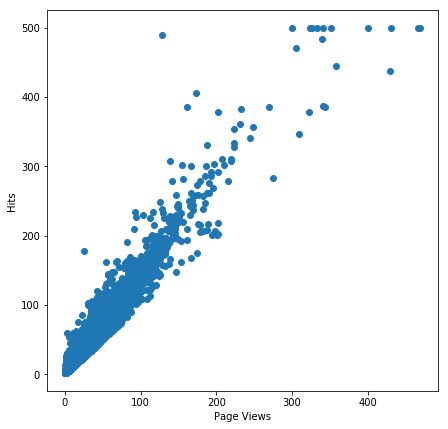

In [38]:
y1 = X_train['totals.hits']
x1 = X_train['totals.pageviews']


plt.figure(figsize = (7,7))
plt.scatter(x1, y1)
plt.xlabel('Page Views')
plt.ylabel('Hits')
plt.show()

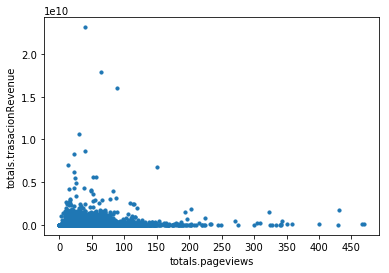

In [39]:
x1 = X_train['totals.pageviews']
y1 = X_train['totals.transactionRevenue']

plt.scatter(x1, y1,s = 10)
plt.xticks(np.arange(0,500,step = 50))
plt.xlabel('totals.pageviews')
plt.ylabel('totals.trasacionRevenue')
plt.show()

In [41]:
X_train['hits_per_pageviews'] = (X_train["totals.hits"]/(X_train["totals.pageviews"])).apply(lambda x: 0 if np.isinf(x) else x)

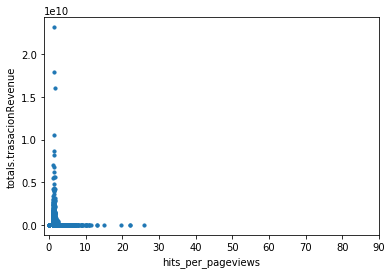

In [42]:
x1 = X_train['hits_per_pageviews']
y1 = X_train['totals.transactionRevenue']

plt.scatter(x1, y1,s = 10)
plt.xticks(np.arange(0,100,step = 10))
plt.xlabel('hits_per_pageviews')
plt.ylabel('totals.trasacionRevenue')
plt.show()

In [45]:
X_train['channelGrouping'].unique()

array(['Organic Search', 'Referral', 'Paid Search', 'Affiliates',
       'Direct', 'Display', 'Social', '(Other)'], dtype=object)

In [43]:
categorical.append('channelGrouping')

In [46]:
X_train['trafficSource.campaign'].unique()

array(['(not set)', 'AW - Dynamic Search Ads Whole Site',
       'Data Share Promo', 'AW - Electronics', 'test-liyuhz',
       'AW - Accessories',
       'Retail (DO NOT EDIT owners nophakun and tianyu)', 'AW - Apparel',
       'All Products', 'Data Share'], dtype=object)

In [44]:
categorical.append('trafficSource.campaign')

In [47]:
X_train['trafficSource.medium'].unique()

array(['organic', 'referral', 'cpc', 'affiliate', '(none)', 'cpm',
       '(not set)'], dtype=object)

In [ ]:
categorical.append('trafficSource.medium')

In [48]:
X_train['trafficSource.source'].unique()

array(['google', 'baidu', 'googleweblight.com', 'sites.google.com',
       'bing', 'siliconvalley.about.com', 'analytics.google.com',
       'Partners', '(direct)', 'mall.googleplex.com', 'google.com',
       'google.co.in', 'qiita.com', 'google.pl', 'mail.google.com',
       'hangouts.google.com', 'dealspotr.com', 'optimize.google.com',
       'arstechnica.com', 'dfa', 'docs.google.com', 'sashihara.jp',
       'google.gatewaycdi.com', 'phandroid.com', 'images.google',
       'youtube.com', 'l.facebook.com', 'facebook.com', 'quora.com',
       'm.facebook.com', 'reddit.com', 'google.co.jp', 'aol',
       'moma.corp.google.com', 'blog.golang.org', 'yahoo', 't.co',
       'nordic.businessinsider.com', 'duckduckgo.com', 'm.baidu.com',
       'tpc.googlesyndication.com', 'googleads.g.doubleclick.net',
       '0.shared.bow.cat2.ads-bow.vu.borg.google.com:9856',
       'online-metrics.com', 'cv.il3.ub.edu', 'gophergala.com',
       'plus.google.com', 's0.2mdn.net', 'keep.google.com',
       

In [49]:
def add_new_category(x):
    x = str(x).lower()
    if 'google' in x:
        return 'google'
    elif 'baidu' in x:
        return 'baidu'
    elif 'facebook' in x:
        return 'facebook'
    elif 'reddit' in x:
        return 'reddit'
    elif 'yahoo' in x:
        return 'yahoo'
    elif 'bing' in x:
        return 'bing'
    elif 'yandex' in x:
        return 'yandex'
    else:
        return 'other'

Identified some repeating values in trafficSource.source. Wrote a function to add the actual names from the substrings in the column.

In [50]:
X_train['trafficSource.source'] = X_train['trafficSource.source'].apply(add_new_category)
X_test['trafficSource.source'] = X_test['trafficSource.source'].apply(add_new_category)

In [52]:
X_train.head()

,channelGrouping,fullVisitorId,sessionId,visitId,visitNumber,visitStartTime,device.browser,device.deviceCategory,device.isMobile,device.operatingSystem,geoNetwork.city,geoNetwork.continent,geoNetwork.country,geoNetwork.metro,geoNetwork.networkDomain,geoNetwork.region,geoNetwork.subContinent,totals.hits,totals.pageviews,totals.transactionRevenue,trafficSource.campaign,trafficSource.keyword,trafficSource.medium,trafficSource.source,day,month,year,weekOfTheYear,hits_per_pageviews
0,Organic Search,1131660440785968503,1131660440785968503_1472830385,1472830385,1,1472830385,Chrome,desktop,0,Windows,Izmir,Asia,Turkey,(not set),ttnet.com.tr,Izmir,Western Asia,1,1,0.0,(not set),other,organic,google,4,9,2016,35,1.0
1,Organic Search,377306020877927890,377306020877927890_1472880147,1472880147,1,1472880147,Firefox,desktop,0,Macintosh,not available in demo dataset,Oceania,Australia,not available in demo dataset,dodo.net.au,not available in demo dataset,Australasia,1,1,0.0,(not set),other,organic,google,4,9,2016,35,1.0
2,Organic Search,3895546263509774583,3895546263509774583_1472865386,1472865386,1,1472865386,Chrome,desktop,0,Windows,Madrid,Europe,Spain,(not set),unknown.unknown,Community of Madrid,Southern Europe,1,1,0.0,(not set),other,organic,google,4,9,2016,35,1.0
3,Organic Search,4763447161404445595,4763447161404445595_1472881213,1472881213,1,1472881213,UC Browser,desktop,0,Linux,not available in demo dataset,Asia,Indonesia,not available in demo dataset,unknown.unknown,not available in demo dataset,Southeast Asia,1,1,0.0,(not set),google,organic,google,4,9,2016,35,1.0
4,Organic Search,27294437909732085,27294437909732085_1472822600,1472822600,2,1472822600,Chrome,mobile,1,Android,not available in demo dataset,Europe,United Kingdom,not available in demo dataset,unknown.unknown,not available in demo dataset,Northern Europe,1,1,0.0,(not set),other,organic,google,4,9,2016,35,1.0


In [51]:
X_train['channelGrouping'].unique()

array(['Organic Search', 'Referral', 'Paid Search', 'Affiliates',
       'Direct', 'Display', 'Social', '(Other)'], dtype=object)

In [ ]:
X_train.head()

In [53]:
len_Xtrain = X_train.shape[0]
len_Xtrain

903653

Deleting the output value from the dataset.

In [54]:
#X_train['totals.transactionRevenue'] = X_train['totals.transactionRevenue'].fillna(0).astype(float)
Y_train = X_train['totals.transactionRevenue'].fillna(0).astype(float)
Y_train = Y_train.apply(lambda x: np.log(x) if x > 0 else x)
del X_train['totals.transactionRevenue']

In [55]:
df_all = pd.concat([X_train, X_test])

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


Appending more categorical values

In [56]:
categorical += ['day', 'month', 'year', 'weekOfTheYear', 'trafficSource.source', 'trafficSource.keyword', 'trafficSource.medium']

In [57]:
categorical

['device.browser',
 'device.deviceCategory',
 'device.operatingSystem',
 'geoNetwork.city',
 'geoNetwork.continent',
 'geoNetwork.country',
 'geoNetwork.metro',
 'geoNetwork.networkDomain',
 'geoNetwork.region',
 'geoNetwork.subContinent',
 'channelGrouping',
 'trafficSource.campaign',
 'day',
 'month',
 'year',
 'weekOfTheYear',
 'trafficSource.source',
 'trafficSource.keyword']

In [58]:
X_train['totals.transactionRevenue'] = Y_train

In [ ]:
X_train.head()

For buyer prediction, creating a copy of X_train and adding buyornobuy feature to it.

In [59]:
prob_df = X_train
prob_df.loc[X_train['totals.transactionRevenue']>0, 'buyornobuy'] = 1
prob_df.loc[X_train['totals.transactionRevenue']<=0, 'buyornobuy'] = 0
prob_df.tail()

,channelGrouping,fullVisitorId,sessionId,visitId,visitNumber,visitStartTime,device.browser,device.deviceCategory,device.isMobile,device.operatingSystem,geoNetwork.city,geoNetwork.continent,geoNetwork.country,geoNetwork.metro,geoNetwork.networkDomain,geoNetwork.region,geoNetwork.subContinent,totals.hits,totals.pageviews,trafficSource.campaign,trafficSource.keyword,trafficSource.medium,trafficSource.source,day,month,year,weekOfTheYear,hits_per_pageviews,totals.transactionRevenue,buyornobuy
903648,Social,5123779100307500332,5123779100307500332_1483554750,1483554750,1,1483554750,Chrome,desktop,0,Windows,not available in demo dataset,Americas,Puerto Rico,not available in demo dataset,prtc.net,not available in demo dataset,Caribbean,17,15,(not set),nan,referral,other,2,1,2017,1,1.133333,0.0,0.0
903649,Social,7231728964973959842,7231728964973959842_1483543798,1483543798,1,1483543798,Chrome,mobile,1,Android,not available in demo dataset,Asia,Sri Lanka,not available in demo dataset,unknown.unknown,not available in demo dataset,Southern Asia,18,13,(not set),nan,referral,other,2,1,2017,1,1.384615,0.0,0.0
903650,Social,5744576632396406899,5744576632396406899_1483526434,1483526434,1,1483526434,Android Webview,mobile,1,Android,Seoul,Asia,South Korea,(not set),unknown.unknown,Seoul,Eastern Asia,24,21,(not set),nan,referral,other,2,1,2017,1,1.142857,0.0,0.0
903651,Social,2709355455991750775,2709355455991750775_1483592857,1483592857,1,1483592864,Chrome,desktop,0,Windows,not available in demo dataset,Asia,Indonesia,not available in demo dataset,unknown.unknown,not available in demo dataset,Southeast Asia,24,22,(not set),nan,referral,facebook,2,1,2017,1,1.090909,0.0,0.0
903652,Social,0814900163617805053,0814900163617805053_1483574474,1483574474,1,1483574474,Chrome,mobile,1,Android,not available in demo dataset,Americas,Mexico,not available in demo dataset,cybercable.net.mx,not available in demo dataset,Central America,31,31,(not set),nan,referral,other,2,1,2017,1,1.000000,0.0,0.0


Label encoding the newly created df 

In [60]:
from sklearn.preprocessing import LabelEncoder
for col in categorical:
    lbl = LabelEncoder()
    prob_df[col] = lbl.fit_transform(prob_df[col])

In [61]:
prob_df.head()

,channelGrouping,fullVisitorId,sessionId,visitId,visitNumber,visitStartTime,device.browser,device.deviceCategory,device.isMobile,device.operatingSystem,geoNetwork.city,geoNetwork.continent,geoNetwork.country,geoNetwork.metro,geoNetwork.networkDomain,geoNetwork.region,geoNetwork.subContinent,totals.hits,totals.pageviews,trafficSource.campaign,trafficSource.keyword,trafficSource.medium,trafficSource.source,day,month,year,weekOfTheYear,hits_per_pageviews,totals.transactionRevenue,buyornobuy
0,4,1131660440785968503,1131660440785968503_1472830385,1472830385,1,1472830385,11,0,0,16,258,3,204,0,24932,150,21,1,1,0,2,organic,3,4,8,0,34,1.0,0.0,0.0
1,4,377306020877927890,377306020877927890_1472880147,1472880147,1,1472880147,16,0,0,7,648,5,12,93,6673,375,1,1,1,0,2,organic,3,4,8,0,34,1.0,0.0,0.0
2,4,3895546263509774583,3895546263509774583_1472865386,1472865386,1,1472865386,11,0,0,16,325,4,181,0,25841,78,19,1,1,0,2,organic,3,4,8,0,34,1.0,0.0,0.0
3,4,4763447161404445595,4763447161404445595_1472881213,1472881213,1,1472881213,46,0,0,6,648,3,94,93,25841,375,16,1,1,0,0,organic,3,4,8,0,34,1.0,0.0,0.0
4,4,27294437909732085,27294437909732085_1472822600,1472822600,2,1472822600,11,1,1,1,648,4,211,93,25841,375,13,1,1,0,2,organic,3,4,8,0,34,1.0,0.0,0.0


Before training LGBM for predicting probability scores.

In [62]:
tmp_probdf = pd.DataFrame()
tmp_probdf['fullVisitorId'] = prob_df['fullVisitorId']
tmp_probdf['sessionId'] = prob_df['sessionId']
tmp_probdf['visitId'] = prob_df['visitId']
prob_df.drop(['fullVisitorId', 'sessionId', 'visitId'], inplace = True, axis = 1)
prob_df.head()

,channelGrouping,visitNumber,visitStartTime,device.browser,device.deviceCategory,device.isMobile,device.operatingSystem,geoNetwork.city,geoNetwork.continent,geoNetwork.country,geoNetwork.metro,geoNetwork.networkDomain,geoNetwork.region,geoNetwork.subContinent,totals.hits,totals.pageviews,trafficSource.campaign,trafficSource.keyword,trafficSource.medium,trafficSource.source,day,month,year,weekOfTheYear,hits_per_pageviews,totals.transactionRevenue,buyornobuy
0,4,1,1472830385,11,0,0,16,258,3,204,0,24932,150,21,1,1,0,2,organic,3,4,8,0,34,1.0,0.0,0.0
1,4,1,1472880147,16,0,0,7,648,5,12,93,6673,375,1,1,1,0,2,organic,3,4,8,0,34,1.0,0.0,0.0
2,4,1,1472865386,11,0,0,16,325,4,181,0,25841,78,19,1,1,0,2,organic,3,4,8,0,34,1.0,0.0,0.0
3,4,1,1472881213,46,0,0,6,648,3,94,93,25841,375,16,1,1,0,0,organic,3,4,8,0,34,1.0,0.0,0.0
4,4,2,1472822600,11,1,1,1,648,4,211,93,25841,375,13,1,1,0,2,organic,3,4,8,0,34,1.0,0.0,0.0


In [63]:
from sklearn.model_selection import StratifiedKFold
import lightgbm as lgb
FOLDs = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)
clf = lgb.LGBMClassifier(class_weight='balanced', objective= 'binary',max_depth=8, colsample_bytree=0.8,learning_rate=0.01, min_child_samples=20, reg_alpha=1, reg_lambda=1, 
                    num_leaves=257, subsample=0.8)


In [64]:
X = prob_df.loc[:, categorical]
Y = prob_df["buyornobuy"]

In [65]:
oof_lgb = np.zeros(len(prob_df))
predictions_lgb = np.zeros(len(prob_df))

In [66]:
features_lgb = list(X.columns)
feature_importance_df_lgb = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(FOLDs.split(X, Y)):
    trn_data = lgb.Dataset(X.iloc[trn_idx], label=Y.iloc[trn_idx])
    val_data = lgb.Dataset(X.iloc[val_idx], label=Y.iloc[val_idx])


In [67]:
for fold_, (trn_idx, val_idx) in enumerate(FOLDs.split(X, Y)):
    trn_data = lgb.Dataset(X.iloc[trn_idx], label=Y.iloc[trn_idx])
    val_data = lgb.Dataset(X.iloc[val_idx], label=Y.iloc[val_idx])

    print("LGB " + str(fold_) + "-" * 50)
    num_round = 20000
    clf.fit(trn_data.data, trn_data.label, eval_set = [(val_data.data, val_data.label)], verbose = True, early_stopping_rounds = 100)
    oof_lgb[val_idx] = clf.predict(X.iloc[val_idx], num_iteration=clf.best_iteration_)
    fold_importance_df_lgb = pd.DataFrame()
    fold_importance_df_lgb["feature"] = features_lgb
    fold_importance_df_lgb["importance"] = clf.feature_importances_
    fold_importance_df_lgb["fold"] = fold_ + 1
    feature_importance_df_lgb = pd.concat([feature_importance_df_lgb, fold_importance_df_lgb], axis=0)
    #clf_model.booster_ = clf
    #predictions_lgb += clf.predict_proba(X, num_iteration=clf.best_iteration_) / FOLDs.n_splits


LGB 0--------------------------------------------------
[1]	valid_0's binary_logloss: 0.688412
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's binary_logloss: 0.683949
[3]	valid_0's binary_logloss: 0.679427
[4]	valid_0's binary_logloss: 0.674992
[5]	valid_0's binary_logloss: 0.670692
[6]	valid_0's binary_logloss: 0.666556
[7]	valid_0's binary_logloss: 0.66258
[8]	valid_0's binary_logloss: 0.658699
[9]	valid_0's binary_logloss: 0.654701
[10]	valid_0's binary_logloss: 0.650948
[11]	valid_0's binary_logloss: 0.647133
[12]	valid_0's binary_logloss: 0.643589
[13]	valid_0's binary_logloss: 0.640067
[14]	valid_0's binary_logloss: 0.636488
[15]	valid_0's binary_logloss: 0.632973
[16]	valid_0's binary_logloss: 0.629671
[17]	valid_0's binary_logloss: 0.626463
[18]	valid_0's binary_logloss: 0.623154
[19]	valid_0's binary_logloss: 0.619912
[20]	valid_0's binary_logloss: 0.61675
[21]	valid_0's binary_logloss: 0.613709
[22]	valid_0's binary_logloss: 0.610745
[23]	valid_0

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


LGB 1--------------------------------------------------
[1]	valid_0's binary_logloss: 0.688425
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's binary_logloss: 0.684006
[3]	valid_0's binary_logloss: 0.679475
[4]	valid_0's binary_logloss: 0.675049
[5]	valid_0's binary_logloss: 0.670752
[6]	valid_0's binary_logloss: 0.66662
[7]	valid_0's binary_logloss: 0.662647
[8]	valid_0's binary_logloss: 0.658773
[9]	valid_0's binary_logloss: 0.654776
[10]	valid_0's binary_logloss: 0.65106
[11]	valid_0's binary_logloss: 0.647258
[12]	valid_0's binary_logloss: 0.64373
[13]	valid_0's binary_logloss: 0.640215
[14]	valid_0's binary_logloss: 0.636642
[15]	valid_0's binary_logloss: 0.633134
[16]	valid_0's binary_logloss: 0.629841
[17]	valid_0's binary_logloss: 0.626639
[18]	valid_0's binary_logloss: 0.623322
[19]	valid_0's binary_logloss: 0.620078
[20]	valid_0's binary_logloss: 0.61691
[21]	valid_0's binary_logloss: 0.613858
[22]	valid_0's binary_logloss: 0.610904
[23]	valid_0's

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


LGB 2--------------------------------------------------
[1]	valid_0's binary_logloss: 0.688424
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's binary_logloss: 0.683995
[3]	valid_0's binary_logloss: 0.679484
[4]	valid_0's binary_logloss: 0.675054
[5]	valid_0's binary_logloss: 0.670777
[6]	valid_0's binary_logloss: 0.666652
[7]	valid_0's binary_logloss: 0.662702
[8]	valid_0's binary_logloss: 0.658846
[9]	valid_0's binary_logloss: 0.65485
[10]	valid_0's binary_logloss: 0.651133
[11]	valid_0's binary_logloss: 0.647331
[12]	valid_0's binary_logloss: 0.643809
[13]	valid_0's binary_logloss: 0.640317
[14]	valid_0's binary_logloss: 0.636748
[15]	valid_0's binary_logloss: 0.633254
[16]	valid_0's binary_logloss: 0.62998
[17]	valid_0's binary_logloss: 0.626782
[18]	valid_0's binary_logloss: 0.623486
[19]	valid_0's binary_logloss: 0.620251
[20]	valid_0's binary_logloss: 0.617091
[21]	valid_0's binary_logloss: 0.614047
[22]	valid_0's binary_logloss: 0.611101
[23]	valid_0

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


LGB 3--------------------------------------------------
[1]	valid_0's binary_logloss: 0.688427
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's binary_logloss: 0.683979
[3]	valid_0's binary_logloss: 0.679477
[4]	valid_0's binary_logloss: 0.675058
[5]	valid_0's binary_logloss: 0.670774
[6]	valid_0's binary_logloss: 0.666652
[7]	valid_0's binary_logloss: 0.662679
[8]	valid_0's binary_logloss: 0.658802
[9]	valid_0's binary_logloss: 0.654831
[10]	valid_0's binary_logloss: 0.651097
[11]	valid_0's binary_logloss: 0.647283
[12]	valid_0's binary_logloss: 0.643759
[13]	valid_0's binary_logloss: 0.640273
[14]	valid_0's binary_logloss: 0.6367
[15]	valid_0's binary_logloss: 0.63322
[16]	valid_0's binary_logloss: 0.629915
[17]	valid_0's binary_logloss: 0.626728
[18]	valid_0's binary_logloss: 0.623442
[19]	valid_0's binary_logloss: 0.620215
[20]	valid_0's binary_logloss: 0.617059
[21]	valid_0's binary_logloss: 0.614029
[22]	valid_0's binary_logloss: 0.611073
[23]	valid_0'

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


LGB 4--------------------------------------------------
[1]	valid_0's binary_logloss: 0.688401
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's binary_logloss: 0.683948
[3]	valid_0's binary_logloss: 0.679431
[4]	valid_0's binary_logloss: 0.674975
[5]	valid_0's binary_logloss: 0.670664
[6]	valid_0's binary_logloss: 0.666504
[7]	valid_0's binary_logloss: 0.662525
[8]	valid_0's binary_logloss: 0.658639
[9]	valid_0's binary_logloss: 0.654632
[10]	valid_0's binary_logloss: 0.650894
[11]	valid_0's binary_logloss: 0.647075
[12]	valid_0's binary_logloss: 0.643534
[13]	valid_0's binary_logloss: 0.639998
[14]	valid_0's binary_logloss: 0.636409
[15]	valid_0's binary_logloss: 0.632895
[16]	valid_0's binary_logloss: 0.629573
[17]	valid_0's binary_logloss: 0.626366
[18]	valid_0's binary_logloss: 0.623052
[19]	valid_0's binary_logloss: 0.619805
[20]	valid_0's binary_logloss: 0.61662
[21]	valid_0's binary_logloss: 0.613563
[22]	valid_0's binary_logloss: 0.610583
[23]	valid_

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


LGB 5--------------------------------------------------
[1]	valid_0's binary_logloss: 0.68843
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's binary_logloss: 0.684001
[3]	valid_0's binary_logloss: 0.679509
[4]	valid_0's binary_logloss: 0.675099
[5]	valid_0's binary_logloss: 0.670813
[6]	valid_0's binary_logloss: 0.666695
[7]	valid_0's binary_logloss: 0.662744
[8]	valid_0's binary_logloss: 0.6589
[9]	valid_0's binary_logloss: 0.654926
[10]	valid_0's binary_logloss: 0.651218
[11]	valid_0's binary_logloss: 0.647422
[12]	valid_0's binary_logloss: 0.643929
[13]	valid_0's binary_logloss: 0.640419
[14]	valid_0's binary_logloss: 0.636843
[15]	valid_0's binary_logloss: 0.63336
[16]	valid_0's binary_logloss: 0.630086
[17]	valid_0's binary_logloss: 0.626921
[18]	valid_0's binary_logloss: 0.623635
[19]	valid_0's binary_logloss: 0.620408
[20]	valid_0's binary_logloss: 0.617256
[21]	valid_0's binary_logloss: 0.61423
[22]	valid_0's binary_logloss: 0.611285
[23]	valid_0's 

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


LGB 6--------------------------------------------------
[1]	valid_0's binary_logloss: 0.688405
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's binary_logloss: 0.683946
[3]	valid_0's binary_logloss: 0.67942
[4]	valid_0's binary_logloss: 0.674983
[5]	valid_0's binary_logloss: 0.670686
[6]	valid_0's binary_logloss: 0.666553
[7]	valid_0's binary_logloss: 0.662586
[8]	valid_0's binary_logloss: 0.65871
[9]	valid_0's binary_logloss: 0.65472
[10]	valid_0's binary_logloss: 0.650992
[11]	valid_0's binary_logloss: 0.647178
[12]	valid_0's binary_logloss: 0.64365
[13]	valid_0's binary_logloss: 0.640132
[14]	valid_0's binary_logloss: 0.636552
[15]	valid_0's binary_logloss: 0.633045
[16]	valid_0's binary_logloss: 0.629747
[17]	valid_0's binary_logloss: 0.626562
[18]	valid_0's binary_logloss: 0.623257
[19]	valid_0's binary_logloss: 0.620022
[20]	valid_0's binary_logloss: 0.61684
[21]	valid_0's binary_logloss: 0.613795
[22]	valid_0's binary_logloss: 0.610834
[23]	valid_0's 

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


LGB 7--------------------------------------------------
[1]	valid_0's binary_logloss: 0.688419
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's binary_logloss: 0.68397
[3]	valid_0's binary_logloss: 0.679465
[4]	valid_0's binary_logloss: 0.675033
[5]	valid_0's binary_logloss: 0.670741
[6]	valid_0's binary_logloss: 0.666602
[7]	valid_0's binary_logloss: 0.662614
[8]	valid_0's binary_logloss: 0.658741
[9]	valid_0's binary_logloss: 0.654745
[10]	valid_0's binary_logloss: 0.650989
[11]	valid_0's binary_logloss: 0.647177
[12]	valid_0's binary_logloss: 0.643642
[13]	valid_0's binary_logloss: 0.640129
[14]	valid_0's binary_logloss: 0.636545
[15]	valid_0's binary_logloss: 0.633042
[16]	valid_0's binary_logloss: 0.629728
[17]	valid_0's binary_logloss: 0.626544
[18]	valid_0's binary_logloss: 0.623241
[19]	valid_0's binary_logloss: 0.620002
[20]	valid_0's binary_logloss: 0.616833
[21]	valid_0's binary_logloss: 0.613787
[22]	valid_0's binary_logloss: 0.610824
[23]	valid_

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


LGB 8--------------------------------------------------
[1]	valid_0's binary_logloss: 0.68841
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's binary_logloss: 0.683986
[3]	valid_0's binary_logloss: 0.679474
[4]	valid_0's binary_logloss: 0.675045
[5]	valid_0's binary_logloss: 0.670735
[6]	valid_0's binary_logloss: 0.666592
[7]	valid_0's binary_logloss: 0.662621
[8]	valid_0's binary_logloss: 0.658741
[9]	valid_0's binary_logloss: 0.654744
[10]	valid_0's binary_logloss: 0.651007
[11]	valid_0's binary_logloss: 0.647192
[12]	valid_0's binary_logloss: 0.643685
[13]	valid_0's binary_logloss: 0.640163
[14]	valid_0's binary_logloss: 0.636574
[15]	valid_0's binary_logloss: 0.633071
[16]	valid_0's binary_logloss: 0.629775
[17]	valid_0's binary_logloss: 0.626588
[18]	valid_0's binary_logloss: 0.623285
[19]	valid_0's binary_logloss: 0.620052
[20]	valid_0's binary_logloss: 0.616885
[21]	valid_0's binary_logloss: 0.613837
[22]	valid_0's binary_logloss: 0.610871
[23]	valid_

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


LGB 9--------------------------------------------------
[1]	valid_0's binary_logloss: 0.688439
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's binary_logloss: 0.684044
[3]	valid_0's binary_logloss: 0.679552
[4]	valid_0's binary_logloss: 0.675145
[5]	valid_0's binary_logloss: 0.670871
[6]	valid_0's binary_logloss: 0.666761
[7]	valid_0's binary_logloss: 0.66282
[8]	valid_0's binary_logloss: 0.658977
[9]	valid_0's binary_logloss: 0.655005
[10]	valid_0's binary_logloss: 0.651297
[11]	valid_0's binary_logloss: 0.647501
[12]	valid_0's binary_logloss: 0.64401
[13]	valid_0's binary_logloss: 0.640516
[14]	valid_0's binary_logloss: 0.636949
[15]	valid_0's binary_logloss: 0.633471
[16]	valid_0's binary_logloss: 0.630191
[17]	valid_0's binary_logloss: 0.627016
[18]	valid_0's binary_logloss: 0.623728
[19]	valid_0's binary_logloss: 0.620508
[20]	valid_0's binary_logloss: 0.617373
[21]	valid_0's binary_logloss: 0.614344
[22]	valid_0's binary_logloss: 0.611403
[23]	valid_0

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


This predicts a numerical value whether an user will buy from the GStore or not.

In [68]:
ypred = clf.predict(X, num_iteration=clf.best_iteration_)

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Converting the numerically predictied values into softmax scores.

In [69]:
def softmax(X, theta = 1.0, axis = None):

    y = np.atleast_2d(X)


    if axis is None:
        axis = next(j[0] for j in enumerate(y.shape) if j[1] > 1)

    y = y * float(theta)

    y = y - np.expand_dims(np.max(y, axis = axis), axis)

    y = np.exp(y)

    ax_sum = np.expand_dims(np.sum(y, axis = axis), axis)

    p = y / ax_sum

    if len(X.shape) == 1: p = p.flatten()

    return p

In [70]:
yproba = clf.predict_proba(X, clf.best_iteration_)
yproba = softmax(yproba, axis = 1)
buyprob = yproba[:,1]

toptenbuyers = []
for i in range(10):
    top = buyprob.argmax()
    toptenbuyers.append(top)
    buyprob[top] = 0
buyers = []
for i in toptenbuyers:
    buyers.append(tmp_probdf.loc[i,'fullVisitorId'])


printing the sorted values of buyers

In [71]:
buyers

['8946514554986669717',
 '700225401855286769',
 '4064008221273566105',
 '4064008221273566105',
 '3980601042365877663',
 '3087800167641443127',
 '6180179196714828509',
 '8518736572243003083',
 '7048142789651941273',
 '5179586107192059934',
 '7308095176976751222',
 '8652691250363359598',
 '2752688798072608210']

In [72]:
newX = pd.read_csv("../input/kernel-for-data/train-flat.csv", low_memory = False)
tmp = pd.DataFrame()

In [73]:
for i in buyers: 
    tmp = pd.concat([tmp,newX[newX['fullVisitorId'] == i]])

Below are further details of the buyers according their fullvisitor ID

In [74]:
tmp

,channelGrouping,date,fullVisitorId,sessionId,socialEngagementType,visitId,visitNumber,visitStartTime,device.browser,device.browserSize,device.browserVersion,device.deviceCategory,device.flashVersion,device.isMobile,device.language,device.mobileDeviceBranding,device.mobileDeviceInfo,device.mobileDeviceMarketingName,device.mobileDeviceModel,device.mobileInputSelector,device.operatingSystem,device.operatingSystemVersion,device.screenColors,device.screenResolution,geoNetwork.city,geoNetwork.cityId,geoNetwork.continent,geoNetwork.country,geoNetwork.latitude,geoNetwork.longitude,geoNetwork.metro,geoNetwork.networkDomain,geoNetwork.networkLocation,geoNetwork.region,geoNetwork.subContinent,totals.bounces,totals.hits,totals.newVisits,totals.pageviews,totals.transactionRevenue,totals.visits,trafficSource.adContent,trafficSource.adwordsClickInfo.adNetworkType,trafficSource.adwordsClickInfo.criteriaParameters,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.campaign,trafficSource.campaignCode,trafficSource.isTrueDirect,trafficSource.keyword,trafficSource.medium,trafficSource.referralPath,trafficSource.source
3353,Referral,20170126,8946514554986669717,8946514554986669717_1485446384,Not Socially Engaged,1485446384,5,1485446384,Chrome,not available in demo dataset,not available in demo dataset,desktop,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,Macintosh,not available in demo dataset,not available in demo dataset,not available in demo dataset,Ann Arbor,not available in demo dataset,Americas,United States,not available in demo dataset,not available in demo dataset,Detroit MI,(not set),not available in demo dataset,Michigan,Northern America,NaN,20,NaN,16.0,30720000.0,1,NaN,NaN,not available in demo dataset,NaN,NaN,NaN,NaN,(not set),NaN,True,NaN,referral,/,mall.googleplex.com
613649,Referral,20161121,8946514554986669717,8946514554986669717_1479758126,Not Socially Engaged,1479758126,2,1479758126,Chrome,not available in demo dataset,not available in demo dataset,desktop,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,Macintosh,not available in demo dataset,not available in demo dataset,not available in demo dataset,Ann Arbor,not available in demo dataset,Americas,United States,not available in demo dataset,not available in demo dataset,Detroit MI,(not set),not available in demo dataset,Michigan,Northern America,NaN,6,NaN,6.0,NaN,1,NaN,NaN,not available in demo dataset,NaN,NaN,NaN,NaN,(not set),NaN,True,NaN,referral,/,mall.googleplex.com
3391,Referral,20170126,700225401855286769,700225401855286769_1485443740,Not Socially Engaged,1485443740,1,1485443740,Chrome,not available in demo dataset,not available in demo dataset,desktop,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,Macintosh,not available in demo dataset,not available in demo dataset,not available in demo dataset,Ann Arbor,not available in demo dataset,Americas,United States,not available in demo dataset,not available in demo dataset,Detroit MI,(not set),not available in demo dataset,Michigan,Northern America,NaN,34,1.0,28.0,179160000.0,1,NaN,NaN,not available in demo dataset,NaN,NaN,NaN,NaN,(not set),NaN,NaN,NaN,referral,/,mall.googleplex.com
6671,Referral,20170623,4064008221273566105,4064008221273566105_1498245824,Not Socially Engaged,1498245824,3,1498245824,Chrome,not available in demo dataset,not available in demo dataset,desktop,not available in demo dataset,False,not avai

In [75]:
X_train.head()

,channelGrouping,visitNumber,visitStartTime,device.browser,device.deviceCategory,device.isMobile,device.operatingSystem,geoNetwork.city,geoNetwork.continent,geoNetwork.country,geoNetwork.metro,geoNetwork.networkDomain,geoNetwork.region,geoNetwork.subContinent,totals.hits,totals.pageviews,trafficSource.campaign,trafficSource.keyword,trafficSource.medium,trafficSource.source,day,month,year,weekOfTheYear,hits_per_pageviews,totals.transactionRevenue,buyornobuy
0,4,1,1472830385,11,0,0,16,258,3,204,0,24932,150,21,1,1,0,2,organic,3,4,8,0,34,1.0,0.0,0.0
1,4,1,1472880147,16,0,0,7,648,5,12,93,6673,375,1,1,1,0,2,organic,3,4,8,0,34,1.0,0.0,0.0
2,4,1,1472865386,11,0,0,16,325,4,181,0,25841,78,19,1,1,0,2,organic,3,4,8,0,34,1.0,0.0,0.0
3,4,1,1472881213,46,0,0,6,648,3,94,93,25841,375,16,1,1,0,0,organic,3,4,8,0,34,1.0,0.0,0.0
4,4,2,1472822600,11,1,1,1,648,4,211,93,25841,375,13,1,1,0,2,organic,3,4,8,0,34,1.0,0.0,0.0


Prepping the data for training, encoding labels to all values appended in the categorical column

In [76]:
from sklearn.preprocessing import LabelEncoder
for col in categorical:
    lbl = LabelEncoder()
    df_all[col] = lbl.fit_transform(df_all[col])

In [81]:
df_all.head()

,channelGrouping,day,device.browser,device.deviceCategory,device.isMobile,device.operatingSystem,fullVisitorId,geoNetwork.city,geoNetwork.continent,geoNetwork.country,geoNetwork.metro,geoNetwork.networkDomain,geoNetwork.region,geoNetwork.subContinent,hits_per_pageviews,month,sessionId,totals.hits,totals.pageviews,trafficSource.campaign,trafficSource.keyword,trafficSource.medium,trafficSource.source,visitId,visitNumber,visitStartTime,weekOfTheYear,year
0,4,4,35,0,0,20,1131660440785968503,378,3,210,0,37454,193,21,1.0,8,1131660440785968503_1472830385,1,1,4,2,5,3,1472830385,1,1472830385,34,0
1,4,4,43,0,0,7,377306020877927890,955,5,12,122,10098,482,1,1.0,8,377306020877927890_1472880147,1,1,4,2,5,3,1472880147,1,1472880147,34,0
2,4,4,35,0,0,20,3895546263509774583,475,4,185,0,38725,99,19,1.0,8,3895546263509774583_1472865386,1,1,4,2,5,3,1472865386,1,1472865386,34,0
3,4,4,79,0,0,6,4763447161404445595,955,3,94,122,38725,482,16,1.0,8,4763447161404445595_1472881213,1,1,4,0,5,3,1472881213,1,1472881213,34,0
4,4,4,35,1,1,1,27294437909732085,955,4,217,122,38725,482,13,1.0,8,27294437909732085_1472822600,1,1,4,2,5,3,1472822600,2,1472822600,34,0


In [82]:
X_train = df_all[:len_Xtrain]
X_test = df_all[len_Xtrain:]

In [83]:
X_train.head()

,channelGrouping,day,device.browser,device.deviceCategory,device.isMobile,device.operatingSystem,fullVisitorId,geoNetwork.city,geoNetwork.continent,geoNetwork.country,geoNetwork.metro,geoNetwork.networkDomain,geoNetwork.region,geoNetwork.subContinent,hits_per_pageviews,month,sessionId,totals.hits,totals.pageviews,trafficSource.campaign,trafficSource.keyword,trafficSource.medium,trafficSource.source,visitId,visitNumber,visitStartTime,weekOfTheYear,year
0,4,4,35,0,0,20,1131660440785968503,378,3,210,0,37454,193,21,1.0,8,1131660440785968503_1472830385,1,1,4,2,5,3,1472830385,1,1472830385,34,0
1,4,4,43,0,0,7,377306020877927890,955,5,12,122,10098,482,1,1.0,8,377306020877927890_1472880147,1,1,4,2,5,3,1472880147,1,1472880147,34,0
2,4,4,35,0,0,20,3895546263509774583,475,4,185,0,38725,99,19,1.0,8,3895546263509774583_1472865386,1,1,4,2,5,3,1472865386,1,1472865386,34,0
3,4,4,79,0,0,6,4763447161404445595,955,3,94,122,38725,482,16,1.0,8,4763447161404445595_1472881213,1,1,4,0,5,3,1472881213,1,1472881213,34,0
4,4,4,35,1,1,1,27294437909732085,955,4,217,122,38725,482,13,1.0,8,27294437909732085_1472822600,1,1,4,2,5,3,1472822600,2,1472822600,34,0


In [84]:
X_train_fullVisitorId = X_train['fullVisitorId']
X_train_sessionId = X_train['sessionId']
X_train_visitId = X_train['visitId']

In [85]:
X_test_fullVisitorId = X_test['fullVisitorId']
X_test_sessionId = X_test['sessionId']
X_test_visitId = X_test['visitId']

In [87]:
X_train.drop(['fullVisitorId', 'sessionId', 'visitId'], axis=1, inplace=True)
X_test.drop(['fullVisitorId', 'sessionId', 'visitId'], axis=1, inplace=True)

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [ ]:
list(X_train.columns)

In [88]:
tmp = []
not_col = ['fullVisitorId','sessionId','visitId']
for col in X_train.columns:
    if col not in not_col:
        tmp.append(col)

Computing the Pscore 

In [89]:
from sklearn.feature_selection import f_regression
X = X_train.loc[:, tmp]
F, pval = f_regression(X=X, y = Y_train)

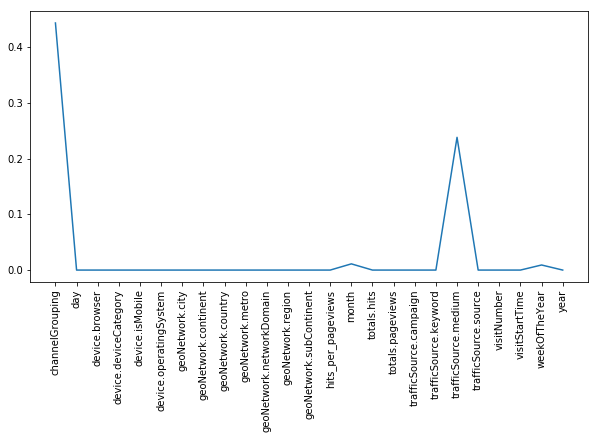

In [90]:
plt.figure(figsize = (10,5))
plt.plot(tmp,pval)
plt.xticks(rotation=90)
plt.show()

In [ ]:
categorical

Model training

In [91]:
params = {
        "objective" : "regression",
        "metric" : "rmse", 
        "num_leaves" : 30,
        "min_child_samples" : 100,
        "learning_rate" : 0.1,
        "bagging_fraction" : 0.7,
        "feature_fraction" : 0.5,
        "bagging_frequency" : 5,
        "bagging_seed" : 1989,
        "verbosity" : -1,
        'seed': 1989
    }

In [92]:
from sklearn.model_selection import KFold
import time
import lightgbm as lgb

folds = KFold(n_splits=5, shuffle=True, random_state=15)
oof = np.zeros(len(X_train))
predictions = np.zeros(len(X_test))
start = time.time()
features = list(X_train.columns)
feature_importance_df = pd.DataFrame()

In [96]:
X_train.head()

,channelGrouping,day,device.browser,device.deviceCategory,device.isMobile,device.operatingSystem,geoNetwork.city,geoNetwork.continent,geoNetwork.country,geoNetwork.metro,geoNetwork.networkDomain,geoNetwork.region,geoNetwork.subContinent,hits_per_pageviews,month,totals.hits,totals.pageviews,trafficSource.campaign,trafficSource.keyword,trafficSource.medium,trafficSource.source,visitNumber,visitStartTime,weekOfTheYear,year
0,4,4,35,0,0,20,378,3,210,0,37454,193,21,1.0,8,1,1,4,2,5,3,1,1472830385,34,0
1,4,4,43,0,0,7,955,5,12,122,10098,482,1,1.0,8,1,1,4,2,5,3,1,1472880147,34,0
2,4,4,35,0,0,20,475,4,185,0,38725,99,19,1.0,8,1,1,4,2,5,3,1,1472865386,34,0
3,4,4,79,0,0,6,955,3,94,122,38725,482,16,1.0,8,1,1,4,0,5,3,1,1472881213,34,0
4,4,4,35,1,1,1,955,4,217,122,38725,482,13,1.0,8,1,1,4,2,5,3,2,1472822600,34,0


In [93]:
for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train.values, Y_train.values)):
    trn_data = lgb.Dataset(X_train.iloc[trn_idx], label=Y_train.iloc[trn_idx], categorical_feature=categorical)
    val_data = lgb.Dataset(X_train.iloc[val_idx], label=Y_train.iloc[val_idx], categorical_feature=categorical)
    
    num_round = 10000
    clf = lgb.train(params, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=400, early_stopping_rounds = 500, categorical_feature=categorical)
    oof[val_idx] = clf.predict(X_train.iloc[val_idx].values, num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = features
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions += clf.predict(X_test.values, num_iteration=clf.best_iteration) / folds.n_splits

/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 500 rounds.
[400]	training's rmse: 1.42733	valid_1's rmse: 1.61321
Early stopping, best iteration is:
[146]	training's rmse: 1.50506	valid_1's rmse: 1.60647
Training until validation scores don't improve for 500 rounds.
[400]	training's rmse: 1.41999	valid_1's rmse: 1.61383
Early stopping, best iteration is:
[119]	training's rmse: 1.51056	valid_1's rmse: 1.60702
Training until validation scores don't improve for 500 rounds.
[400]	training's rmse: 1.4241	valid_1's rmse: 1.61938
Early stopping, best iteration is:
[145]	training's rmse: 1.50258	valid_1's rmse: 1.6125
Training until validation scores don't improve for 500 rounds.
[400]	training's rmse: 1.41826	valid_1's rmse: 1.63415
Early stopping, best iteration is:
[128]	training's rmse: 1.50389	valid_1's rmse: 1.62541
Training until validation scores don't improve for 500 rounds.
[400]	training's rmse: 1.42652	valid_1's rmse: 1.60616
Early stopping, best iteration is:
[119]	training's 

In [95]:
submission = pd.DataFrame()

submission['fullVisitorId'] = X_test_fullVisitorId

submission['PredictedLogRevenue'] = predictions

grouped_test = submission[['fullVisitorId', 'PredictedLogRevenue']].groupby('fullVisitorId').sum().reset_index()
grouped_test.to_csv('submit.csv',index=False)

Referenced the following kernel
https://www.kaggle.com/youhanlee/eda-lgbm-for-starter-lb-1-6878